In [2]:
using LinearAlgebra
using Plots
using Test

##########################
# Méthodes Quasi-Newton #
##########################
function BFGS(sₖ, yₖ, Hₖ, Bₖ)
    ρₖ = 1/dot(yₖ, sₖ)
    Hₖ = (I-ρₖ*sₖ*transpose(yₖ))*Hₖ*(I-ρₖ*yₖ*transpose(sₖ)) + ρₖ*sₖ*transpose(sₖ)
    Bₖ += -Bₖ*sₖ*transpose(sₖ)*Bₖ/(dot(sₖ, Bₖ*sₖ)) + yₖ*transpose(yₖ)*ρₖ
    @test norm(Hₖ*yₖ - sₖ) < 10e-6
    @test norm(Bₖ*sₖ - yₖ) < 10e-6
    return(Hₖ, Bₖ)
end

function DFP(sₖ, yₖ, Hₖ, Bₖ)
    ρₖ = 1/dot(yₖ, sₖ)
    Bₖ = (I-ρₖ*yₖ*transpose(sₖ))*Bₖ*(I-ρₖ*sₖ*transpose(yₖ)) + ρₖ*yₖ*transpose(yₖ)
    Hₖ += -Hₖ*yₖ*transpose(yₖ)*Hₖ/(dot(yₖ, Hₖ*yₖ)) + sₖ*transpose(sₖ)*ρₖ
    return(Hₖ, Bₖ)
end

function SR1(sₖ, yₖ, Hₖ, Bₖ)
    b = yₖ - Bₖ*sₖ
    Bₖ += b*transpose(b)/(dot(b, sₖ))
    h = sₖ - Hₖ*yₖ
    Hₖ += h*transpose(h)/(dot(h, yₖ))
    return(Hₖ, Bₖ)
end

SR1 (generic function with 1 method)

In [76]:
# Un problème de minimisation sans contrainte est associé à une fonction, 
# son gradient et la matrice approchant la Hessienne
mutable struct problem
    fonction # Evaluation de la fonction
    gradient # Evaluation du gradient
    Hess # Evaluation de la Hessienne
end

function lineSearch(problem, x₀, Δ; affichage = false, maxiter = 1000, ϵ = 10e-8)
    g = problem.gradient
    gₖ = g(x₀) # Initialisation du gradient au point initial (x₀ := centre de la région de confiance)
    Hₖ = I # Initialisation de Hₖ et de Bₖ
    Bₖ = I
    sₖ = -Hₖ*gₖ # Direction de descente (suivant la méthode BFGS)
    # Calcul de la longueur du pas α minimisant f(x₀ + α*sₖ) (exact dans le cas d'une quadratique convexe)
    B = problem.Hess(x₀)
    α = -dot(gₖ, sₖ)/dot(sₖ, B*sₖ)
    sₖ = α*sₖ # Pas optimal suivant la direction de descente
    # Initilisation de pₖ := Σᵏᵢ₌₁ sᵢ 
    # (c'est le vecteur qui correspondra au minimum ou qui s'en rapprochera le long de la frontière de la RC)
    pₖ = sₖ 
    yₖ = g(x₀ + pₖ) - gₖ
    gₖ += yₖ
    # Sauvegarde à chaque itération de pₖ et de sa norme (pour affichage graphique)
    NormP = [norm(pₖ)]
    P = [pₖ]
    B = problem.Hess(x₀)
    NormB = [norm(Bₖ - B)]
    for k = 0:maxiter
        if(norm(pₖ) >= Δ)
            # Si p traverse la région de confiance on trouve le réel τ ∈ [0, 1]
            # tel que ||s1 + s2 + ... + sk-1 + τ*sₖ|| = Δ
            pₖ += -sₖ # calcul de s1 + s2 + ... + sk-1 (on retire sₖ à pₖ)
            # Suppresion de la dernière mise à jour comme on revient en arrière
            pop!(NormP)
            pop!(P)
            pop!(NormB)
            # Résolution de l'équation du second ordre ||pₙ τ*sₙ||² = Δ²
            # <=> (||pₙ₋₁||² - Δ²) + 2*τ*dot(pₙ₋₁, sₙ) + τ²*||sₙ||² = 0
            a = dot(sₖ, sₖ)
            b = 2*dot(pₖ, sₖ)
            c = dot(pₖ, pₖ) - Δ^2
            δ = b^2 - 4*a*c
            τ = (-b + sqrt(δ))/(2*a)
            # Mise à jour de pₖ
            pₖ += τ*sₖ
            push!(NormP, norm(pₖ))
            push!(P, pₖ)
            push!(NormB, norm(Bₖ - B))
            return(pₖ, NormP, k, P, NormB)
        end
        if(norm(gₖ) <= ϵ) # Convergence
            return(pₖ, NormP, k, P, NormB)
        end
        # Mise à jour de Hₖ par la méthode BFGS
        Hₖ, Bₖ = BFGS(sₖ, yₖ, Hₖ, Bₖ)
        if(affichage)
            println(" -- itération ", k + 1, " : Bₖ = $Bₖ")
        end
        sₖ = -Hₖ*gₖ
        # Recherche de la longueur du pas α minimisant f(p + α*sₖ)
        α = -(dot(gₖ, sₖ))/dot(sₖ, B*sₖ)
        # Mise à jour de sₖ, p yₖ, gₖ suivant leurs définitions respectives
        sₖ = α*sₖ
        pₖ += sₖ
        yₖ = g(x₀ + pₖ) - gₖ
        gₖ += yₖ
        # Concaténation
        push!(NormP, norm(pₖ))
        push!(P, pₖ)
        push!(NormB, norm(Bₖ - B))
    end
    return(pₖ, NormP, maxiter + 1, P, NormB)
end

lineSearch (generic function with 1 method)

In [100]:
function CG(problem, x₀; maxiter = 1000, ϵ = 10e-8)
    A = problem.Hess(x₀)
    rₖ = problem.gradient(x₀)
    pₖ = -rₖ
    k = 0
    xₖ = x₀
    X = []
    normP = []
    while(norm(rₖ) > ϵ && k < maxiter)
        αₖ = -dot(rₖ, pₖ)/dot(pₖ, A*pₖ)
        xₖ += αₖ*pₖ
        if(norm(xₖ) >= Δ)
            # Si p traverse la région de confiance on trouve le réel τ ∈ [0, 1]
            # tel que ||s1 + s2 + ... + sk-1 + τ*sₖ|| = Δ
            sₖ = αₖ*pₖ
            xₖ += -sₖ # calcul de s1 + s2 + ... + sk-1 (on retire sₖ à pₖ)
            # Résolution de l'équation du second ordre ||xₙ₋₁ + τ*αₖ*pₖ||² = Δ²
            # <=> (||xₙ₋₁||² - Δ²) + 2*τ*dot(xₙ₋₁, αₖ*pₖ) + τ²*||αₖ*pₖ||² = 0
            a = dot(sₖ, sₖ)
            b = 2*dot(xₖ, sₖ)
            c = dot(xₖ, xₖ) - Δ^2
            δ = b^2 - 4*a*c
            τ = (-b + sqrt(δ))/(2*a)
            # Mise à jour de pₖ
            xₖ += τ*sₖ
            k += 1
            push!(normP, norm(xₖ - x₀))
            return(xₖ, k, normP)
        end
        rₖ = problem.gradient(xₖ)
        βₖ = dot(rₖ, A*pₖ)/dot(pₖ, A*pₖ)
        pₖ = -rₖ + βₖ*pₖ
        k += 1
        push!(normP, norm(xₖ - x₀))
    end
    return(xₖ, k, normP)
end

CG (generic function with 1 method)

conditionnement de la Hessienne : 3.041713165666796e6
p = [4.61853, 70.2837, 32.2997, 53.6213, -54.4825, -71.2723]
solution exacte : [4.61853, 70.2837, 32.2997, 53.6213, -54.4825, -71.2723]
||p|| = 130.10658032926202
||g(x₀ + p)|| = 8.626306736099196e-11
||g(x₀ + pᵧ)|| = 3.131799354847967e-8
||B - Bₖ|| = [30265.0, 4535.79, 3908.08, 7.29811, 1.12029, 0.98822, 2.35568e-11]


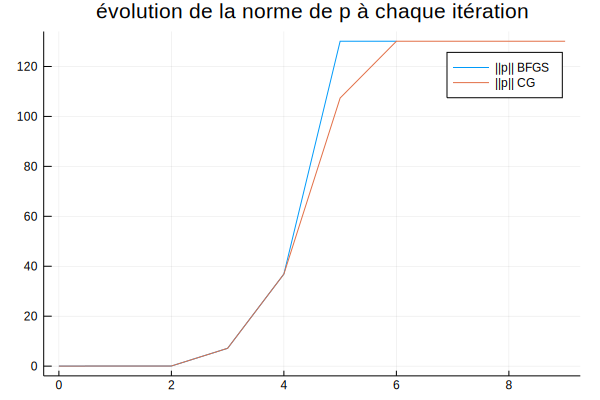

In [101]:
# d = [10e-12, 8e-11, 4e-12, 3e-11, 2e-12, 10e-11] # matrice quasi-singulière et petit conditionnement
d = [10e-3, 8, 4e3, 3e4, 2e2, 10e-2] # matrice avec gros conditionnement
# d = [10e-4, 8e3, 40e-5, 3e4, 2e-4, 10e-2] # matrice quasi-signulière avec gros contionemment (1)
# d = [10e-4, 8e3, 40e5, 3000, 2e-5, 10e-2] # matrice quasi-signulière avec gros contionemment (2)
# d = [10, 5, 3, 2, 1, 4] # matrice normale

D = Diagonal(d)
A = rand(6, 6)
Q, R = qr(A)
A = transpose(Q)*D*Q
b = [1, 2, 3, 4, 5, 6]

g(x) = A*x + b
f(x) = 0.5*dot(x, A*x) + dot(b, x)
B(x) = A
x₀ = [0, 0, 0, 0, 0, 0]
quadratic = problem(f, g, B)

println("conditionnement de la Hessienne : ", norm(A)*norm(inv(A)))

Δ = Inf
p, S, iter, P, normB = lineSearch(quadratic, x₀, Δ, maxiter = 10, ϵ = 10e-10); 
# passé 10e-11 la précision n'est plus suffisante pour arrêter l'algo 
# en N itérations et la reconstitution de la Hessienne se déteriore.

pᵧ, iterᵧ, Pᵧ = CG(quadratic, x₀, maxiter = 30)

println("p = $p")
println("solution exacte : ", -A\b - x₀)
println("||p|| = ", norm(p))
println("||g(x₀ + p)|| = ", norm(g(x₀ + p)))
println("||g(x₀ + pᵧ)|| = ", norm(g(x₀ + pᵧ)))
println("||B - Bₖ|| = ", normB)
plot(0:iter, S, label = "||p|| BFGS", title = "évolution de la norme de p à chaque itération")
#plot!(0:iter, normB, label = "||Bk - B||")
plot!(0:(iterᵧ-1), Pᵧ, label = "||p|| CG")


In [16]:
function createQuadraticConvexe(N = 10)
    b = rand(N)
    C = rand(N, N)
    @test det(C) != 0
    A = transpose(C)*C # Obtention d'une matrice symétrique définie positive (si C non singulier)
    f(x) = dot(b, x) + 0.5*dot(x, A*x)
    g(x) = b + A*x
    B(x) = A
    return(problem(f, g, B))
end

createQuadraticConvexe (generic function with 2 methods)

In [117]:
N = 10
quadratic = createQuadraticConvexe(N)
x₀ = zeros(N);
A = quadratic.Hess(x₀)
println("conditionnement de la Hessienne : ", norm(A)*norm(inv(A)))

conditionnement de la Hessienne : 38718.90713613205


p BFGS = [-19.7591, -44.7973, 138.403, -8.15512, 12.2609, -57.3505, -82.8823, -7.20065, 80.7194, -13.7873]
p CG = [-19.7591, -44.7973, 138.403, -8.15512, 12.2609, -57.3505, -82.8823, -7.20065, 80.7194, -13.7873]
||p|| = 196.68635443167435
||pᵧ|| = 196.68635443184044
||g(x₀ + p)|| BFGS = 2.336376714905913e-13
||g(x₀ + p)|| CG = 5.922522989143482e-10
||B - Bₖ|| = [30.5381, 2.52597, 1.94784, 1.85221, 1.79745, 1.70821, 1.57718, 1.43824, 1.22086, 0.997845, 5.44888e-14]


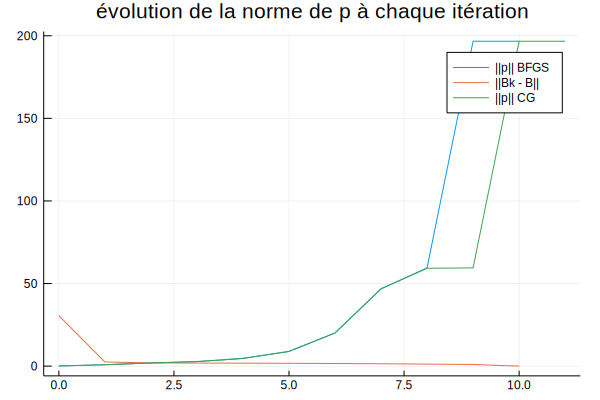

In [118]:
Δ = Inf
p, S, iter, P, normB = lineSearch(quadratic, x₀, Δ, maxiter = 11, ϵ = 10e-10)
pᵧ, iterᵧ, Pᵧ = CG(quadratic, x₀, ϵ = 10e-10)

println("p BFGS = $p")
println("p CG = ", pᵧ - x₀)
println("||p|| = ", norm(p))
println("||pᵧ|| = ", norm(pᵧ))
g(x) = quadratic.gradient(x)
println("||g(x₀ + p)|| BFGS = ", norm(g(p)))
println("||g(x₀ + p)|| CG = ", norm(g(pᵧ)))
println("||B - Bₖ|| = ", normB)

plot(0:iter, S, label = "||p|| BFGS", title = "évolution de la norme de p à chaque itération")
plot!(0:iter, normB, label = "||Bk - B||")
plot!(0:(iterᵧ-1), Pᵧ, label = "||p|| CG")

In [95]:
eigvals(quadratic.Hess(x₀))

10-element Array{Float64,1}:
  0.0017565212095447492
  0.021510287183724674 
  0.15965500773620497  
  0.2727709165327381   
  0.6534362858669682   
  0.9003384389002999   
  1.2877548419915226   
  1.6072832436249367   
  2.2094356161892375   
 25.654044363571902    

In [39]:
T = zeros(length(P) - 1, N) # les sₖ
for i = 2:length(P)
    for j = 1:N
        T[i - 1, j] = P[i][j] - P[i-1][j]
    end
end
A = quadratic.Hess(x₀)
print(T*A*transpose(T))

[1.39509 -2.0874e-15 -2.72229e-15 -5.80353e-17 3.014e-16 -8.63645e-15 6.83534e-14 -7.92032e-13 1.45226e-11 -1.37969e-11; -2.00099e-15 1.21007 -5.907e-15 1.29987e-14 -3.51432e-14 5.03915e-14 -1.75922e-13 2.44366e-12 -4.54777e-11 4.31634e-11; -1.7432e-15 -3.20668e-15 2.34503 5.94536e-14 -1.5903e-13 2.7831e-13 -1.10028e-12 1.53319e-11 -2.85635e-10 2.71226e-10; 3.08301e-16 1.43697e-14 5.74283e-14 1.26901 -4.89843e-14 1.12171e-13 -5.47236e-13 7.70345e-12 -1.43318e-10 1.36098e-10; 1.67565e-15 -3.27183e-14 -1.59112e-13 -4.66222e-14 1.51925 -2.22191e-14 1.61224e-13 -1.86878e-12 3.56358e-11 -3.38402e-11; -7.99421e-15 5.08649e-14 2.74795e-13 1.10898e-13 -3.02063e-14 1.36591 -3.13732e-14 6.40564e-13 -1.22039e-11 1.15912e-11; 6.89294e-14 -1.8034e-13 -1.11774e-12 -5.54814e-13 1.45564e-13 -2.33615e-14 3.45043 9.42375e-13 -1.41573e-11 1.33293e-11; -7.93148e-13 2.45147e-12 1.5336e-11 7.71061e-12 -1.85886e-12 6.75979e-13 9.54717e-13 5.80258 7.76087e-12 -7.62881e-12; 1.45221e-11 -4.54772e-11 -2.8564e-10

In [65]:
# Création d'une matrice particulière (creuse)
N = 6
t = -rand(N-1)
d = rand(N)
A = (Tridiagonal(t, d, t) + I)
b = rand(N)
g(x) = A*x + b
f(x) = 0.5*dot(x, A*x) + dot(b, x)
B(x) = A
println(norm(A)*norm(inv(A)))
x₀ = rand(N)
tridiag = problem(f, g, B)

8.415289688072955


problem(f, g, B)

p BFGS = [-0.255409, -0.742473, -1.27533, -0.720365, -1.05688, -0.951574]
p CG = [-0.255409, -0.742473, -1.27533, -0.720365, -1.05688, -0.951574]
||p|| = 2.187321875526742
||g(x₀ + p)|| BFGS = 2.5438405243138006e-16
||g(x₀ + p)|| CG = 2.7755575615628914e-16
||B - Bₖ|| = [2.2794, 1.92196, 1.4845, 1.30093, 0.802792, 0.506474]


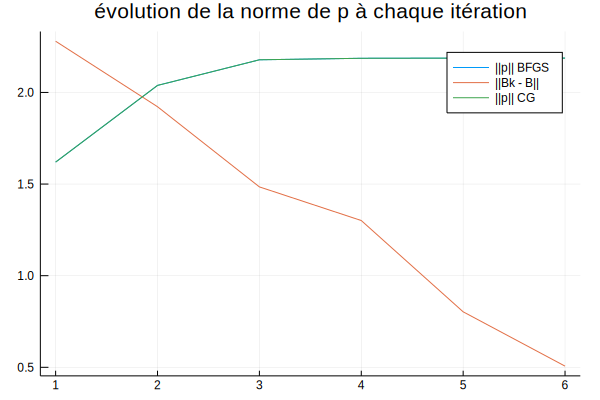

In [66]:
Δ = Inf
p, S, iter, P, normB = lineSearch(tridiag, x₀, Δ,  maxiter = 10, ϵ = 10e-16);
pᵧ, iterᵧ, Pᵧ = CG(tridiag, x₀)

println("p BFGS = $p")
println("p CG = $pᵧ")
println("||p|| = ", norm(p))
println("||g(x₀ + p)|| BFGS = ", norm(g(x₀ + p)))
println("||g(x₀ + p)|| CG = ", norm(g(x₀ + pᵧ)))
println("||B - Bₖ|| = ", normB)
plot(1:(iter + 1), S, label = "||p|| BFGS", title = "évolution de la norme de p à chaque itération")
plot!(1:(iter + 1), normB, label = "||Bk - B||")
plot!(1:iterᵧ, Pᵧ, label = "||p|| CG")

In [640]:
T = zeros(length(P) - 1, N) # les sₖ
for i = 2:length(P)
    for j = 1:N
        T[i - 1, j] = P[i][j] - P[i-1][j]
    end
end
A = tridiag.Hess(x₀) 
print(T*A*transpose(T))

[3.17184 -2.44249e-15 1.35308e-15 9.50628e-16 1.05818e-16; -2.44249e-15 2.89268 1.63758e-15 -1.05471e-15 8.32667e-17; 1.36696e-15 1.51268e-15 0.220265 -1.52222e-16 6.39679e-17; 9.15934e-16 -1.06859e-15 -1.52222e-16 0.0235981 -1.47451e-17; 1.05818e-16 7.80626e-17 6.20164e-17 -1.4962e-17 0.00141909]

In [642]:
# Exemple en dimension 2 avec affichage graphique
# Création d'une matrice particulière (creuse)
N = 2
d = rand(N)
t = -rand(N-1)
A = Tridiagonal(t, d, t) + I
b = rand(N)
g(x) = A*x + b
f(x) = 0.5*dot(x, A*x) + dot(b, x)
B(x) = A
x₀ = rand(N)
tridiag = problem(f, g, B)

println(norm(A)*norm(inv(A)))

x₀ = rand(N)

3.2614911722522275


2-element Array{Float64,1}:
 0.9774138247402657
 0.7271701394549364

Hₖ*yₖ =sₖ ? : true
p = [-1.87563, -2.01925]
||p|| = 2.7559669828050373
||g(x₀ + p)|| = 1.1102230246251565e-16


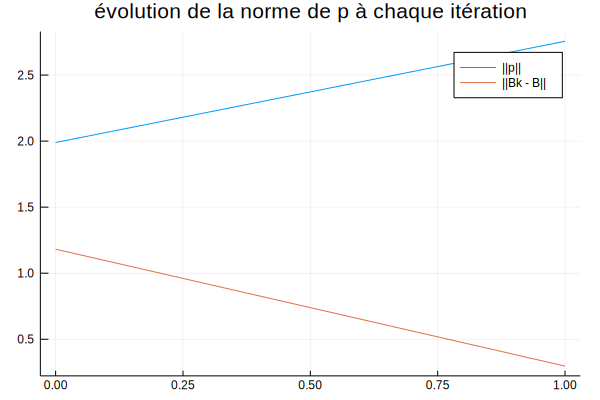

In [643]:
Δ = 5
p, S, iter, P, normB = lineSearch(tridiag, x₀, Δ);

println("p = $p")
println("||p|| = ", norm(p))
println("||g(x₀ + p)|| = ", norm(tridiag.gradient(x₀ + p)))

plot(0:iter, S, label = "||p||", title = "évolution de la norme de p à chaque itération")
plot!(0:iter, normB, label = "||Bk - B||")

In [1]:
x = [x₀[1]]
y = [x₀[2]]
for i= 1:length(P)
    push!(x, P[i][1] + x₀[1])
    push!(y, P[i][2] + x₀[2])
end
f1 = []
f2 = []
X = (-Δ+x₀[1]+0.001):0.001:(Δ+x₀[1]-0.001)
for x = (-Δ+x₀[1]+0.001):0.001:(Δ+x₀[1]-0.001)
    push!(f1, sqrt(Δ^2 - (x - x₀[1])^2) + x₀[2])
    push!(f2, -sqrt(Δ^2 - (x - x₀[1])^2) + x₀[2])
end
plot(X, f1)
plot!(X, f2)
plot!(x, y, label = "||p||")

UndefVarError: UndefVarError: x₀ not defined

In [647]:
# Exemple en dimension 2 avec affichage graphique
# Création d'une matrice particulière (creuse)
N = 2
quadratic = createQuadraticConvexe(N)
x₀ = rand(N)
A = quadratic.Hess(x₀)
println(norm(A)*norm(inv(A)))

6.6966956356358684


Hₖ*yₖ =sₖ ? : true
p = [-0.152327, -1.39169]
||p|| = 1.4
||g(x₀ + p)|| = 0.03496249873179666


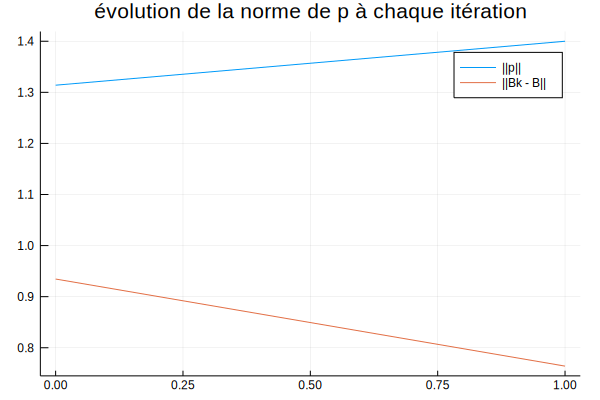

In [654]:
Δ = 1.4
p, S, iter, P, normB = lineSearch(quadratic, x₀, Δ);

println("p = $p")
println("||p|| = ", norm(p))
println("||g(x₀ + p)|| = ", norm(quadratic.gradient(x₀ + p)))

plot(0:iter, S, label = "||p||", title = "évolution de la norme de p à chaque itération")
plot!(0:iter, normB, label = "||Bk - B||")

In [655]:
print(S)

[1.31397, 1.4]

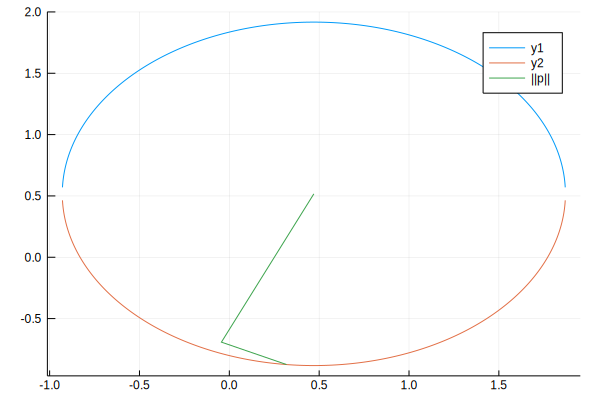

In [656]:
x = [x₀[1]]
y = [x₀[2]]
for i= 1:length(P)
    push!(x, P[i][1] + x₀[1])
    push!(y, P[i][2] + x₀[2])
end
f1 = []
f2 = []
X = (-Δ+x₀[1]+0.001):0.001:(Δ+x₀[1]-0.001)
for x = (-Δ+x₀[1]+0.001):0.001:(Δ+x₀[1]-0.001)
    push!(f1, sqrt(Δ^2 - (x - x₀[1])^2) + x₀[2])
    push!(f2, -sqrt(Δ^2 - (x - x₀[1])^2) + x₀[2])
end
plot(X, f1)
plot!(X, f2)
plot!(x, y, label = "||p||")

In [658]:
T = zeros(length(P) - 1, N) # les sₖ
for i = 2:length(P)
    for j = 1:N
        T[i - 1, j] = P[i][j] - P[i-1][j]
    end
end
A = quadratic.Hess(x₀)
print(T*A*transpose(T))

[0.038636]

2.449489742783178